# Perform a simple deconvolution using Richardson-Lucy

## Load data and prepare operators

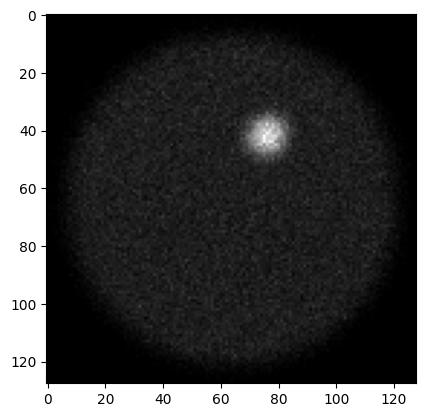

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import richardon_lucy as rl
import noise
import blur
from PIL import Image

device = "cuda"

k_size = 61
k_std = 3.0
n_std = 0.05
n_rate = 0.5

# Load the data
ref = Image.open('img/ellipse.png').convert('L')
ref = torch.from_numpy(np.array(ref)).unsqueeze(0).unsqueeze(0).to(device).float() / 255.0
gaussianblur = blur.GaussianBlur(k_size, k_std).to(device)
k = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)

noiser = noise.PoissonNoise(n_rate)
# noiser = noise.GaussianNoise(n_std)

# Blur the image
y = gaussianblur(ref)

# Add noise
y = noiser(y)

plt.imshow(y[0, 0].detach().cpu().numpy(), cmap='gray')

## Perform the non-blind deconvolution

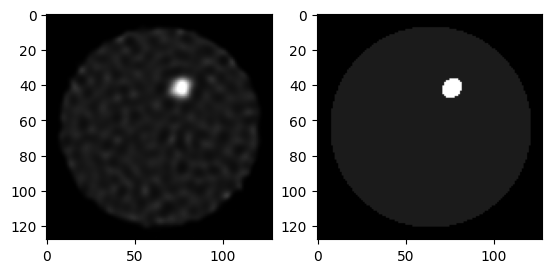

In [63]:
x_0 = torch.ones_like(y) 

res = rl.richardson_lucy(y, x_0, k, steps=50, clip=True, filter_epsilon=1e-6)
plt.subplot(1, 2, 1)
plt.imshow(res[0, 0].detach().cpu().numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(ref[0, 0].detach().cpu().numpy(), cmap='gray')
plt.show()

## Debug blind deconvolution

im_deconv_values :  0.0 1.0
psf values :  1.0900923497203507e-09 0.00021187073434703052


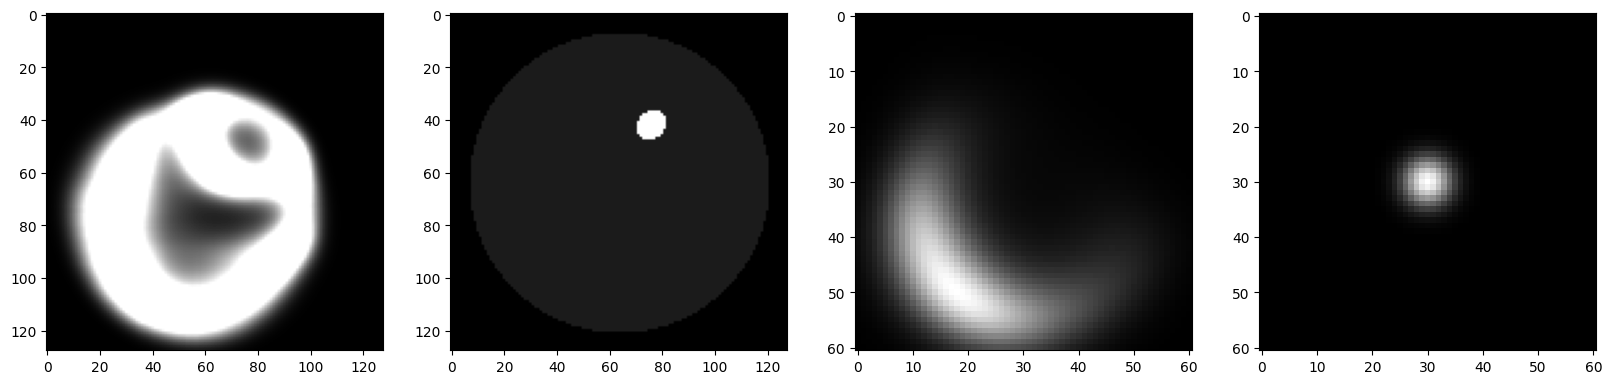

In [68]:
import torch.nn.functional as F

x_0 = torch.ones_like(y)
k_0 = torch.ones_like(k)
steps = 20
filter_epsilon = 1e-6
clip = True
observation = y

with torch.no_grad():
    # kernel = x_0_hat['kernel'].repeat(1, 3, 1, 1)
    
    psf = k_0.clone().float()
    im_deconv = x_0.clone().float()
    k_T = torch.flip(psf, dims=[2, 3])  
    im_deconv_T = torch.flip(im_deconv, dims=[2, 3])

    eps = 1e-12
    pad_im = (psf.size(2) // 2, psf.size(2) // 2, psf.size(3) // 2, psf.size(3) // 2)
    
    # The issue is probably here
    
    
    for i in range(steps):
        
        # Kernel estimation
        conv = F.conv2d(F.pad(im_deconv, pad_im, mode='replicate'), psf) + eps
        if filter_epsilon:
            relative_blur = torch.where(conv < filter_epsilon, 0.0, observation / conv)
        else:
            relative_blur = observation / conv
        
        if(i % 2):
            pad_k = (im_deconv.size(2) // 2, im_deconv.size(2) // 2 - 1, im_deconv.size(3) // 2, im_deconv.size(3) // 2 - 1)
        else:
            pad_k = (im_deconv.size(2) // 2 - 1, im_deconv.size(2) // 2, im_deconv.size(3) // 2 - 1, im_deconv.size(3) // 2)
            
        im_mean = F.conv2d(F.pad(torch.ones_like(psf), pad_k, mode='replicate'), im_deconv)
        
        if filter_epsilon:
            psf = torch.where(im_mean < filter_epsilon, 0.0, psf / im_mean)
        else:
            psf /= im_mean

        psf *= F.conv2d(F.pad(relative_blur, pad_im, mode='replicate'), im_deconv_T) + eps
        
        k_T = torch.flip(psf, dims=[2, 3])  
        
        # Image estimation
        conv = F.conv2d(F.pad(im_deconv, pad_im, mode='replicate'), psf) + eps
        
        if filter_epsilon:
            relative_blur = torch.where(conv < filter_epsilon, 0.0, observation / conv)
        else:
            relative_blur = observation / conv
        
        k_mean = F.conv2d(F.pad(torch.ones_like(im_deconv), pad_im, mode='replicate'), k_T)
        
        if filter_epsilon:
            im_deconv = torch.where(k_mean < filter_epsilon, 0.0, im_deconv / k_mean)
        else:
            im_deconv /= k_mean
        
        im_deconv *= F.conv2d(F.pad(relative_blur, pad_im, mode='replicate'), k_T) + eps

        im_deconv_T = torch.flip(im_deconv, dims=[2, 3])

    if clip:
        im_deconv = torch.clamp(im_deconv, 0, 1)

print("im_deconv_values : ", im_deconv.min().item(), im_deconv.max().item())
print("psf values : ", psf.min().item(), psf.max().item())

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(im_deconv[0, 0].detach().cpu().numpy(), cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(ref[0, 0].detach().cpu().numpy(), cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(psf[0, 0].detach().cpu().numpy(), cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(k[0, 0].detach().cpu().numpy(), cmap='gray')

plt.show()